In [2]:
#import thingsss
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [3]:
#methods
#tokenize the code and convert to tensors
#tokenizer will return input_id and attention_mask
#input_id is based on the pretrained model that i used
#attention mask is the whether the code will be ignored by the model later on
#whether the code is context or important os fucntion call
def tokenize_data(code, tokenizer):

    encoding = tokenizer.batch_encode_plus(
        code.tolist(),  # Convert the DataFrame/Series to a list
        add_special_tokens=True,  # Adds the special tokens like [CLS] and [SEP]
        padding=True,  # Pad sequences to the same length
        truncation=True,  # Truncate sequences that are too long
        max_length=512,  # Adjust according to your model's max input length
        return_tensors="pt"  # Return PyTorch tensors
    )
    return encoding["input_ids"], encoding["attention_mask"]


In [4]:
#init the things
python_dataset_name = "/content/drive/MyDrive/websec/dataset/python_vuln_CyberNative.csv"
php_dataset_name = "/content/drive/MyDrive/websec/dataset/php_vuln_CyberNative.csv"
cpp_dataset_name = '/content/drive/MyDrive/websec/model/c++.csv'
#load CodeBERT tokenizer and model
MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#convert csv into df
python_df = pd.read_csv(python_dataset_name)
print(type(python_df))
php_df = pd.read_csv(php_dataset_name)
cpp_df = pd.read_csv(cpp_dataset_name)
#remove row with null for chosen and rejected columns from php_df
php_df = php_df.dropna(subset=['chosen', 'rejected'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

<class 'pandas.core.frame.DataFrame'>


<ipython-input-4-3e9ded5084bc>:13: DtypeWarning: Columns (5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  cpp_df = pd.read_csv(cpp_dataset_name)


In [5]:
def ensure_no_null_values(dataset_df):
    """
    Checks for null values in the dataset and prints columns with their null count.

    Parameters:
        dataset_df (pd.DataFrame): The input dataset.
    """
    null_counts = dataset_df.isnull().sum()
    print(null_counts)
    for column, count in null_counts.items():
        if count > 0:
            print(f"Column '{column}' has {count} null values.")

In [6]:
print(cpp_df)
#remove row with null for chosen and rejected columns from php_df
cpp_df = cpp_df.dropna(subset=['target', 'func'])
ensure_no_null_values(cpp_df)

                                                     func target  \
0       int _gnutls_ciphertext2compressed(gnutls_sessi...      1   
1       static char *make_filename_safe(const char *fi...      1   
2       unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...      1   
3       static void cirrus_do_copy(CirrusVGAState *s, ...      1   
4       glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...      1   
...                                                   ...    ...   
207948  static av_cold int dnxhd_decode_init_thread_co...      0   
207949  static int dnxhd_decode_header(DNXHDContext *c...      0   
207950  static int dnxhd_init_vlc(DNXHDContext *ctx, u...      0   
207951  static void recalculate_apic_map(struct kvm *k...      0   
207952  vtp_print (netdissect_options *ndo,\n         ...      0   

                           cwe  project  \
0                           []   gnutls   
1                  ['CWE-264']  php-src   
2                           []  busybox   
3          

In [12]:
#see the dataset
#print(python_df.head())

#break the dataset with labels; chosen column = target 0 ;rejected = target 1
# Ensure the 'target' column is numeric
# List of web-related CWE
# Define the list of relevant CWEs
# Define the list of relevant CWEs
web_related_cwe = [
    'CWE-20', 'CWE-79', 'CWE-200', 'CWE-119',
    'CWE-399', 'CWE-416', 'CWE-264', 'CWE-362', 'CWE-284'
]
cpp_df = cpp_df[cpp_df['target'] != 8]
dataset = cpp_df

### **Fix the target column (Remove invalid values)**
dataset['target'] = pd.to_numeric(dataset['target'], errors='coerce')
dataset = dataset.dropna(subset=['target'])  # Remove rows where target is NaN
dataset['target'] = dataset['target'].astype(int)  # Convert target to integer

print("Fixed Target Value Counts:")
print(dataset["target"].value_counts())

# Safely process the 'cwe' column
def safe_process_cwe(val):
    if isinstance(val, str):
        try:
            result = eval(val)  # Convert string representation of list to actual list
            return result if isinstance(result, list) else [result]  # Ensure it's a list
        except:
            return []  # Return empty list if conversion fails
    elif isinstance(val, list):
        return val  # Already a list
    elif isinstance(val, (int, float)):  # If it's a number, convert to empty list
        return []
    else:
        return []  # Default to empty list

# Apply the function to 'cwe' column
dataset['cwe'] = dataset['cwe'].apply(safe_process_cwe)

# Ensure 'cwe' column is properly formatted
print(dataset['cwe'].head())

# Normalize CWE values (remove spaces and ensure uppercase)
dataset['cwe'] = dataset['cwe'].apply(lambda x: [cwe.strip().upper() for cwe in x])

# Filter dataset for vulnerable code (target=1) and relevant CWEs
filtered_dataset = dataset[(dataset['target'] == 1) &
                           (dataset['cwe'].apply(lambda x: any(cwe in web_related_cwe for cwe in x)))]

# Combine with non-vulnerable code (target=0) to balance the dataset
non_vulnerable_dataset = dataset[dataset['target'] == 0]

# Concatenate both datasets
final_dataset = pd.concat([filtered_dataset, non_vulnerable_dataset], ignore_index=True)


# Print dataset shape before filtering columns
print("Final dataset shape (before column selection):", final_dataset.shape)

# Select only 'func' and 'target' columns
final_dataset = final_dataset[['func', 'target']]

# Print dataset shape after filtering columns
print("Final dataset shape (after column selection):", final_dataset.shape)
number_of_1 = final_dataset[final_dataset['target'] == 1].shape[0]
print(number_of_1)


#select the row with target 1 and select the equal number of 0 to be added into CPP_dataset
CPP_dataset = final_dataset[final_dataset['target'] == 1]

CPP_dataset_0 = final_dataset[final_dataset['target'] == 0].sample(n=number_of_1, random_state=42)

# Combine both datasets
CPP_dataset = pd.concat([CPP_dataset, CPP_dataset_0]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print the final dataset shape
print("Final CPP_dataset shape:", CPP_dataset.shape)


<ipython-input-12-b486973f949f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['target'].astype(int)  # Convert target to integer


Fixed Target Value Counts:
target
0    191440
1     13606
Name: count, dtype: int64


<ipython-input-12-b486973f949f>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cwe'] = dataset['cwe'].apply(safe_process_cwe)


0           []
1    [CWE-264]
2           []
3    [CWE-787]
4    [CWE-787]
Name: cwe, dtype: object


<ipython-input-12-b486973f949f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cwe'] = dataset['cwe'].apply(lambda x: [cwe.strip().upper() for cwe in x])


Final dataset shape (before column selection): (196127, 9)
Final dataset shape (after column selection): (196127, 2)
4687
Final CPP_dataset shape: (9374, 2)


In [15]:
#spliiting of the dataset
#split into train (70%), val (20%), test (10%)
train_code, temp_code, train_labels, temp_labels = train_test_split(
    CPP_dataset['func'], CPP_dataset['target'], test_size=0.3, random_state=42
)
print(type(train_code))
print(type(train_labels))

# 33% of temp(30%) is 10 % validation
val_code, test_code, val_labels, test_labels = train_test_split(
    temp_code, temp_labels, test_size=0.33, random_state=42
)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [16]:
#tokenize the code to get the input_id and attention_mask
#these are all tensor type so later i can put into tensor dataset then subse
#dataloader for training
print(train_code.head())
print(type(train_code))
train_code_ids, train_attention_mask = tokenize_data(train_code, tokenizer)
val_code_ids, val_attention_mask = tokenize_data(val_code, tokenizer)
test_code_ids, test_attention_mask = tokenize_data(test_code, tokenizer)
#label also need convert to tensor
train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)
test_labels_tensor = torch.tensor(test_labels.values)


8929    tsize_t t2p_sample_realize_palette(T2P* t2p, u...
3577    njs_vmcode_typeof(njs_vm_t *vm, njs_value_t *v...
4075    static void __hrtimer_init(struct hrtimer *tim...
5500    static void rdp_read_bitmap_cache_cell_info(wS...
378     struct net *get_net_ns_by_id(struct net *net, ...
Name: func, dtype: object
<class 'pandas.core.series.Series'>


In [17]:
#merge train_code_ids and train_attention_mask into one tensor as the input tensor
train_input_tensor = torch.cat((train_code_ids, train_attention_mask), dim=1)
val_input_tensor = torch.cat((val_code_ids, val_attention_mask), dim=1)
test_input_tensor = torch.cat((test_code_ids, test_attention_mask), dim=1)

#create tensor dataset
#split according to X tensor and y tensor , X tensor is input with input id and attention mask
#they are the same size size of inputid == size of attention mask
#lastly is label tensor
train_dataset = TensorDataset(train_input_tensor ,train_labels_tensor)
val_dataset = TensorDataset(val_input_tensor,val_labels_tensor)
test_dataset = TensorDataset(test_input_tensor, test_labels_tensor)

#create train val and test dataloader with batch size 8
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)


In [18]:
#just some pretty viewing of the dataloader before model training
for batch in train_dataloader:
    # Assuming the batch is a tuple: (input_tensor, labels)
    input_tensor, labels = batch

    # Split the input tensor back into input_ids and attention_mask
    input_ids = input_tensor[:, :input_tensor.shape[1] // 2]  # First half: input_ids
    attention_mask = input_tensor[:, input_tensor.shape[1] // 2:]  # Second half: attention_mask

    # Convert the first sequence in the batch back to code (text)
    decoded_code = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    print(f"Decoded Code: \n{decoded_code}\n")
    print(f"Attention Mask: {attention_mask[0]}")  # Print attention mask for the first example
    print(f"Label: {labels[0]}")  # Print the label for the first example

    break  # Just print one batch

Decoded Code: 
GF_Err stbl_box_write(GF_Box *s, GF_BitStream *bs)
{
	return gf_isom_box_write_header(s, bs);
}

Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:

from transformers import RobertaForSequenceClassification, AdamW
from tqdm import tqdm

# Load the RobertaForSequenceClassification model
model_name = "microsoft/codebert-base"
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Function for training the model
def train(model, train_dataloader, val_dataloader, optimizer, epochs=3):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        all_labels = []
        all_predictions = []

        # Training loop
        for batch in tqdm(train_dataloader):
            input_tensor, labels = batch
            input_ids = input_tensor[:, :input_tensor.shape[1] // 2]
            attention_mask = input_tensor[:, input_tensor.shape[1] // 2:]

            # Move data to GPU if available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Collect predictions and labels for metrics
            predictions = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

        # Calculate training metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader):.4f} - "
              f"Accuracy: {accuracy:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}")

        # Validation after each epoch
        validate(model, val_dataloader)

# Function to evaluate on the validation set
def validate(model, val_dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_tensor, labels = batch
            input_ids = input_tensor[:, :input_tensor.shape[1] // 2]
            attention_mask = input_tensor[:, input_tensor.shape[1] // 2:]

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Validation Accuracy: {accuracy:.4f} - Validation Recall: {recall:.4f} - Validation F1 Score: {f1:.4f}")
    model.train()

# Training the model
train(model, train_dataloader, val_dataloader, optimizer)



pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

100%|██████████| 821/821 [10:20<00:00,  1.32it/s]


Epoch 1/3 - Loss: 0.6265 - Accuracy: 0.6581 - Recall: 0.6581 - F1 Score: 0.6581
Validation Accuracy: 0.6948 - Validation Recall: 0.6948 - Validation F1 Score: 0.6947


100%|██████████| 821/821 [10:21<00:00,  1.32it/s]


Epoch 2/3 - Loss: 0.5454 - Accuracy: 0.7290 - Recall: 0.7290 - F1 Score: 0.7286
Validation Accuracy: 0.6826 - Validation Recall: 0.6826 - Validation F1 Score: 0.6744


100%|██████████| 821/821 [10:21<00:00,  1.32it/s]


Epoch 3/3 - Loss: 0.4283 - Accuracy: 0.8092 - Recall: 0.8092 - F1 Score: 0.8090
Validation Accuracy: 0.7314 - Validation Recall: 0.7314 - Validation F1 Score: 0.7312


In [20]:
for batch in val_dataloader:
            input_tensor, labels = batch
            input_ids = input_tensor[:, :input_tensor.shape[1] // 2]
            attention_mask = input_tensor[:, input_tensor.shape[1] // 2:]

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            print("X train " , input_ids.shape)
            print(" Y train " , labels.shape)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)
            print(predictions.shape)

            break

X train  torch.Size([8, 512])
 Y train  torch.Size([8])
torch.Size([8])


all_labels 929
all_predictions 929
all labels, [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0

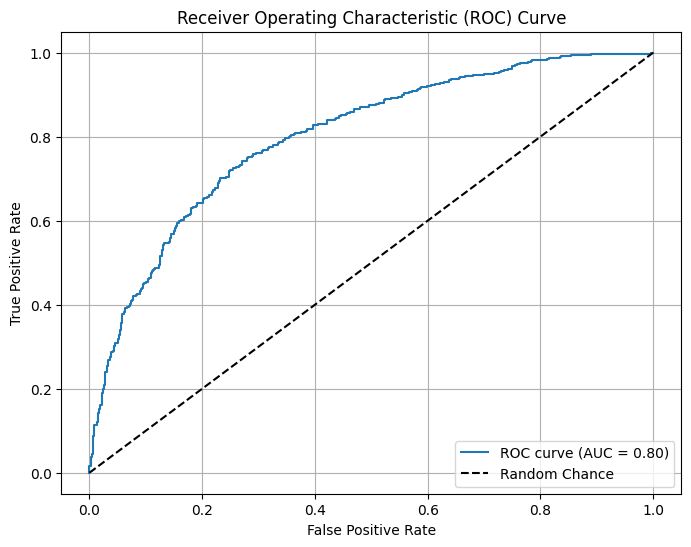

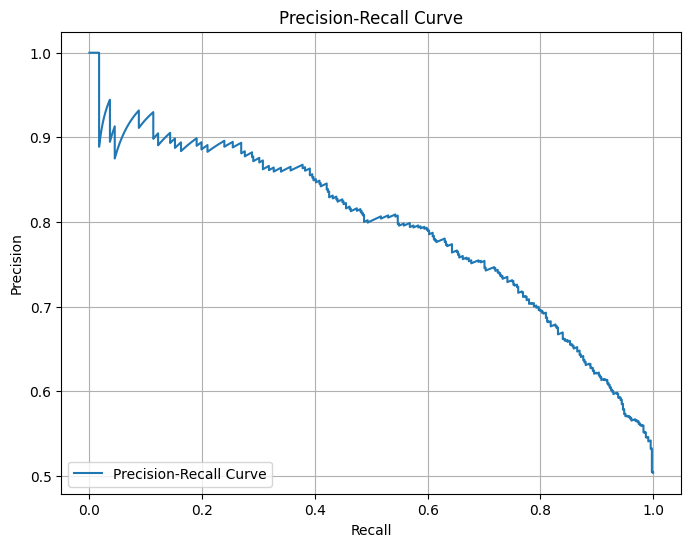

Candidate Thresholds with Recall >= 0.90:
Threshold: 0.00 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.01 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.02 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.03 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.04 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.05 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.06 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.07 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 461 | FN: 0
Threshold: 0.08 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 459 | FN: 0
Threshold: 0.09 | Precision: 0.51 | Recall: 1.00 | F1: 0.68 | FP: 448 | FN: 1
Threshold: 0.10 | Precision: 0.52 | Recall: 1.00 | F1: 0.69 | FP: 424 | FN: 1
Threshold: 0.11 | Precision: 0.54 | Recall: 1.00 | F1: 0.70 | FP: 401 | FN: 2
Threshold: 0.12 | Prec

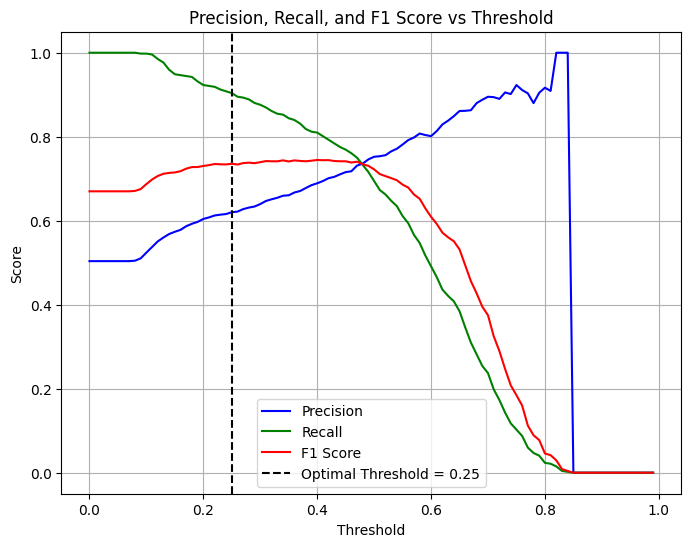

In [21]:

# Function to evaluate the model with unseen test set
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

global_y_score = []
global_y_label = []
def test(model, test_dataloader,device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in test_dataloader:
            input_tensor, labels = batch
            input_ids = input_tensor[:, :input_tensor.shape[1] // 2]
            attention_mask = input_tensor[:, input_tensor.shape[1] // 2:]

            # Move data to the appropriate device (GPU/CPU)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Model inference (forward pass)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Apply sigmoid to get probabilities
            probabilities = torch.sigmoid(logits)

            # Get predictions by taking the class with the highest logit value
            predictions = torch.argmax(logits, dim=-1)

            # Extract probability of class 1
            class_1_probs = probabilities[:, 1]  # Selects probability for class 1

            # Store probabilities in global_y_score
            global_y_score.extend(class_1_probs.cpu().numpy())


            # Store predictions and actual labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate test metrics
    print("all_labels", len(all_labels))
    print("all_predictions", len(all_predictions))
    print("all labels,", all_labels)
    print("all predictions,", all_predictions)

    # Overall accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # Precision, Recall, and F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)

    # Print the test results in a structured format
    print(f"{'':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}")
    print(f"{'Not Vuln':<10}{precision[0]:<10.2f}{recall[0]:<10.2f}{f1[0]:<10.2f}")
    print(f"{'Vuln':<10}{precision[1]:<10.2f}{recall[1]:<10.2f}{f1[1]:<10.2f}")
    print(f"\n{'Accuracy':<10}{accuracy:.4f}")

    # Ensure predicted probabilities are in a 1D array
    y_true = all_labels
    print(y_true)
    y_scores = global_y_score
    print(y_scores)

    # --------------------------
    # 1. ROC Curve
    # --------------------------
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc_value = auc(fpr, tpr)

    print("ROC AUC:", roc_auc_value)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # --------------------------
    # 2. Precision-Recall Curve
    # --------------------------
    precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # --------------------------
    # 3. Grid Search for Optimal Threshold
    # --------------------------
    # Create an array of candidate thresholds
    candidate_thresholds = np.arange(0.0, 1.0, 0.01)
    metrics_list = []

    # Loop through each candidate threshold to calculate performance metrics
    for threshold in candidate_thresholds:
        # Convert probabilities to class predictions based on the current threshold
        y_pred_thresh = (y_scores >= threshold).astype(int)

        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()

        # Calculate precision, recall, and F1 score
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = f1_score(y_true, y_pred_thresh)

        metrics_list.append({
            'threshold': threshold,
            'precision': precision_val,
            'recall': recall_val,
            'f1': f1,
            'false_positives': fp,
            'false_negatives': fn
        })

    # Display metrics for candidate thresholds with high recall (e.g., recall >= 0.90)
    target_recall = 0.90
    print("Candidate Thresholds with Recall >= 0.90:")
    for m in metrics_list:
        if m['recall'] >= target_recall:
            print(f"Threshold: {m['threshold']:.2f} | Precision: {m['precision']:.2f} | Recall: {m['recall']:.2f} | F1: {m['f1']:.2f} | FP: {m['false_positives']} | FN: {m['false_negatives']}")

    # Select the optimal threshold.
    # For instance, choose the threshold with the highest F1 score among those with recall >= target_recall.
    eligible_thresholds = [m for m in metrics_list if m['recall'] >= target_recall]
    if eligible_thresholds:
        best_metric = max(eligible_thresholds, key=lambda x: x['f1'])
        optimal_threshold = best_metric['threshold']
        print(f"\nOptimal Threshold Selected: {optimal_threshold:.2f}")
    else:
        optimal_threshold = 0.5  # Default threshold if no candidate meets the target recall
        print("\nNo candidate threshold met the target recall. Using default threshold 0.5.")

    # Apply the optimal threshold to obtain final class predictions
    y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

    # Optional: Display confusion matrix for the chosen threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_optimal).ravel()
    print("\nConfusion Matrix at Optimal Threshold:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    # --------------------------
    # Plot Precision, Recall, and F1 scores vs Threshold
    # --------------------------
    thresholds = [m['threshold'] for m in metrics_list]
    precisions = [m['precision'] for m in metrics_list]
    recalls = [m['recall'] for m in metrics_list]
    f1_scores = [m['f1'] for m in metrics_list]

    # Plot Precision, Recall, and F1 scores against Thresholds
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions, label='Precision', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='green')
    plt.plot(thresholds, f1_scores, label='F1 Score', color='red')



    # Highlight the selected optimal threshold
    plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score vs Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Run the model on test dataloader
test(model, test_dataloader, device)

#save on google drive model and tokenizer
model.save_pretrained("/content/drive/MyDrive/websec/model/php_xformer/model")
tokenizer.save_pretrained("/content/drive/MyDrive/websec/model/php_xformer/token")
#zip
import shutil
# Zip the directory into a file
shutil.make_archive("/content/drive/MyDrive/websec/model/php_xformer", 'zip', '/content/drive/MyDrive/websec/model', 'php_xformer')


In [23]:

# save model as pth state file
torch.save(model.state_dict(), '/content/drive/MyDrive/websec/model/xformer_cpp_model.pth')

#to use the model
#from transformers import RobertaForSequenceClassification
# Initialize the model
#model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# Load the saved model state_dict
#model.load_state_dict(torch.load('/content/drive/MyDrive/websec/model/xformer_python_model.pth'))
# Set the model to evaluation mode if you're not training
#model.eval()
# Verify the model is loaded properly
#print(model)